In [175]:
import json
import networkx as nx
graph_data = []
with open("./graph_full3.json","r") as f:
    graph_data = json.load(f)["graphs"]

In [176]:
graphs = []
for i in graph_data:
    graphs.append(nx.adjacency_graph(i))


In [177]:


class Client(object):
    def __init__(self, bw_air_interface=0, server=None):
        self.bw_air_interface = bw_air_interface
        self.server = server

    def get_delay(self, gragh,  gragh_data_size):
        pass


class OldClinet(Client):
    def get_delay(self, gragh,  gragh_data_size):
        order = list(nx.topological_sort(gragh))
        delay = 0.
        in_degree_map = dict(gragh.in_degree())

        for node in order:
            pre_node_numebr = in_degree_map[node]
            # first node also need data transmission
            if pre_node_numebr == 0:
                pre_node_numebr = 1

            delay += self.server.get_delay(
                data_size=gragh_data_size * pre_node_numebr, peer_bw=self.bw_air_interface)
        return delay


class newClinet(Client):
    def get_delay(self, gragh,  gragh_data_size):
        delay = 0.
        delay += self.server.get_delay(data_size=gragh_data_size,
                                       gragh=gragh, peer_bw=self.bw_air_interface)
        return delay


class Server(object):
    def __init__(self, bw_inner_network=100,  faas_server=None):
        self.bw_inner_network = bw_inner_network
        self.server = faas_server

    # actual bw is bounded by the minimal bw of peer_bw and inner_network_bw
    def get_delay(self, gragh: nx.Graph, data_size, peer_bw):
        bw = min(peer_bw, self.bw_inner_network)
        delay = 0.
        order = list(nx.topological_sort(gragh))
        in_degree_map = dict(gragh.in_degree())

        # request faas
        for node in order:
            pre_node_numebr = in_degree_map[node]
            # first node also need data transmission
            if pre_node_numebr == 0:
                pre_node_numebr = 1
            # transmitted all data of pre_node
            # this would be data_size* pre_node_numebr
            delay += self.server.get_delay(data_size=data_size *
                                           pre_node_numebr, peer_bw=self.bw_inner_network)

        return delay+((data_size*8.0) / bw)*2


class FaaSServer(object):
    def __init__(self, bw_inner_network=100, compute_delay=0):
        self.compute_delay = compute_delay
        self.bw_inner_network = bw_inner_network

    # actual bw is bounded by the minimal bw of peer_bw and inner_network_bw
    def get_delay(self, data_size, peer_bw):
        bw = min(peer_bw, self.bw_inner_network)
        return self.compute_delay + ((data_size*8.0) / bw)*2


19.68

In [179]:
faas_server=FaaSServer(bw_inner_network=100,compute_delay=0)
server=Server(bw_inner_network=100,faas_server=faas_server)
nc= newClinet(bw_air_interface=10,server=server)
nc.get_delay(gragh = graphs[5],gragh_data_size=1.0)

5.76

In [352]:
old_output = []
new_output = []

for inner_bw in (100,):
    for air_bw in (20,40,60,80,100):
        if air_bw > inner_bw :
            continue

        # share by all
        faas_server=FaaSServer(bw_inner_network=inner_bw,compute_delay=0)
        # for this new algorithm
        server=Server(bw_inner_network=inner_bw,faas_server=faas_server) 
        # for old clinet(old algorithm)
        oc= OldClinet(bw_air_interface=air_bw,server=faas_server)
        # for new clien(new algorithm)
        nc= newClinet(bw_air_interface=air_bw,server=server) 

        for g in graphs:
            old_output.append((oc.get_delay(gragh = g,gragh_data_size=1.0),"%d/%d"%(air_bw,inner_bw)))
            new_output.append((nc.get_delay(gragh = g,gragh_data_size=1.0),"%d/%d"%(air_bw,inner_bw)))





In [366]:
import pandas as pd
df_old = pd.DataFrame(old_output,columns=["Time(Secs)","Air/Inner Bandwith(Mbps/Mbps)"] )
df_new = pd.DataFrame(new_output,columns=["Time(Secs)","Air/Inner Bandwith(Mbps/Mbps)"] )
df_new["type"] = "New"
df_old["type"] = "Old"

In [367]:
# import pandas as pd
# pd_new =  pd.DataFrame(new_dict)
# pd_old = pd.DataFrame(old_dict)

# pd_new = pd_new.reindex(pd_new.mean().sort_values(ascending=False).index, axis=1)
# pd_old = pd_old.reindex(pd_new.mean().sort_values(ascending=False).index, axis=1)

In [368]:
df_old

,Time(Secs),Air/Inner Bandwith(Mbps/Mbps),type
0,24.00,20/100,Old
1,24.80,20/100,Old
2,24.80,20/100,Old
3,30.40,20/100,Old
4,19.20,20/100,Old
...,...,...,...
2495,7.20,100/100,Old
2496,3.20,100/100,Old
2497,3.84,100/100,Old
2498,5.76,100/100,Old


In [369]:
data = df_new.append(df_old)

Text(0.5, 1.0, 'Delay Time')

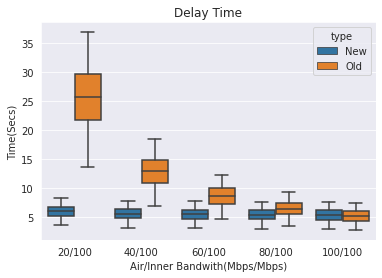

In [370]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid',{'font.DejaVuSansMono':['SimHei', 'Arial']})#设置图表背景颜色字体
sns.boxplot(y="Time(Secs)",data=data,x='Air/Inner Bandwith(Mbps/Mbps)',hue="type")
plt.title('Delay Time')
#plt.savefig('gender.png',dpi=400)


In [365]:
data

,Secs,Bandwith,type
0,5.60,20/100,New
1,5.76,20/100,New
2,5.76,20/100,New
3,6.88,20/100,New
4,4.64,20/100,New
...,...,...,...
2495,7.20,100/100,Old
2496,3.20,100/100,Old
2497,3.84,100/100,Old
2498,5.76,100/100,Old


(0.0, 10.0)

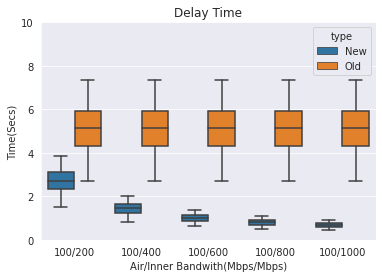

In [377]:
old_output = []
new_output = []

for inner_bw in (200,400,600,800,1000):
    for air_bw in (100,):
        if air_bw > inner_bw :
            continue

        # share by all
        faas_server=FaaSServer(bw_inner_network=inner_bw,compute_delay=0)
        # for this new algorithm
        server=Server(bw_inner_network=inner_bw,faas_server=faas_server) 
        # for old clinet(old algorithm)
        oc= OldClinet(bw_air_interface=air_bw,server=faas_server)
        # for new clien(new algorithm)
        nc= newClinet(bw_air_interface=air_bw,server=server) 

        for g in graphs:
            old_output.append((oc.get_delay(gragh = g,gragh_data_size=1.0),"%d/%d"%(air_bw,inner_bw)))
            new_output.append((nc.get_delay(gragh = g,gragh_data_size=1.0),"%d/%d"%(air_bw,inner_bw)))


import pandas as pd
df_old = pd.DataFrame(old_output,columns=["Time(Secs)","Air/Inner Bandwith(Mbps/Mbps)"] )
df_new = pd.DataFrame(new_output,columns=["Time(Secs)","Air/Inner Bandwith(Mbps/Mbps)"] )
df_new["type"] = "New"
df_old["type"] = "Old"

data = df_new.append(df_old)

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid',{'font.DejaVuSansMono':['SimHei', 'Arial']})#设置图表背景颜色字体
sns.boxplot(y="Time(Secs)",data=data,x='Air/Inner Bandwith(Mbps/Mbps)',hue="type")
plt.title('Delay Time')

plt.ylim((0, 10))
